In [1]:
import sys
sys.path.append('/home/stef/Tb/reaction_mapping')
from utils import load_json, save_json, is_balanced, neutralize_atoms, count_atoms
from rdkit import Chem
from rdkit.Chem import AllChem
s2m = Chem.MolFromSmiles
m2s = Chem.MolToSmiles
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd

# Read in imt rules
def load_rules(path):
    rules = []
    with open(path, 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        for row in reader:
            rules.append(row)

    rules = rules[1:] # Remove header
    return rules

In [2]:
# Check atom balance 

pwy = load_json('../artifacts/mevalonate_pathway.json')

for k, v in pwy.items():
    print(k, is_balanced(v))

rxn_0 True
rxn_1 True
rxn_2 True
rxn_3 True
rxn_4 True
rxn_5 True


In [3]:
# Neutralize atoms and save neutralized pathway

neutral_pwy = {}
for id, rxn in pwy.items():
    neutral_pwy[id] = [{}, {}]
    for i, side in enumerate(rxn):
        for k, cpd in side.items():
            neutral_cpd = Chem.MolToSmiles(neutralize_atoms(Chem.MolFromSmiles(cpd)))
            neutral_pwy[id][i][k] = neutral_cpd

save_json(neutral_pwy, '../artifacts/mevalonate_pathway_neutralized.json')

How many enzymes are in each rule / how distributed?

In [4]:
# Read in rules
imt_path = '/home/stef/Tb/reaction_mapping/mapping/JN3604IMT_rules.tsv'
min_path = '/home/stef/Tb/reaction_mapping/mapping/minimal1224_all_uniprot.tsv'

imt_rules = load_rules(imt_path)
min_rules = load_rules(min_path)

# Create {name:list_of_enzymes}
rule_dicts = []
for elt in [min_rules, imt_rules]:
    elt_transpose = list(zip(*elt))
    this_dict = {}
    for i in range(len(elt)):
        this_dict[elt_transpose[0][i]] = elt_transpose[-1][i].split(';')
    rule_dicts.append(this_dict)

min2enz, imt2enz = rule_dicts
min_enz_cts = list(map(len, min2enz.values()))
imt_enz_cts = list(map(len, imt2enz.values()))
min_ave_enz = sum(min_enz_cts) / len(min_rules)
imt_ave_enz = sum(imt_enz_cts) / len(imt_rules)

print("Ave # enzymes. Min: {}, Imt: {}".format(min_ave_enz, imt_ave_enz))

Ave # enzymes. Min: 26.491013071895424, Imt: 62.48640399556049


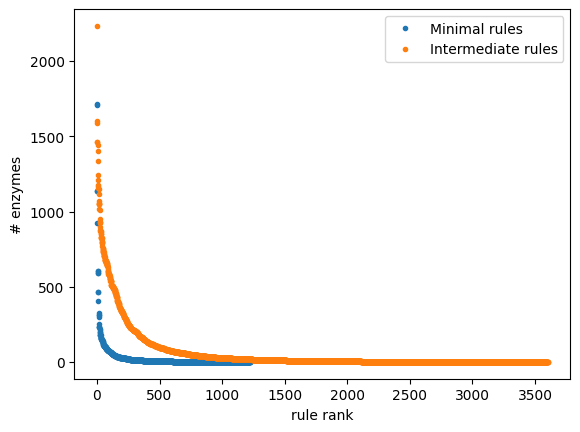

In [33]:
srt_min_names, srt_min_cts = list(zip(*[(elt[1], elt[0]) for elt in sorted(list(zip(min_enz_cts, min2enz.keys())), reverse=True)]))
srt_imt_names, srt_imt_cts = list(zip(*[(elt[1], elt[0]) for elt in sorted(list(zip(imt_enz_cts, imt2enz.keys())), reverse=True)]))

width = 0.3
fig, ax = plt.subplots()
ax.plot(srt_min_cts, '.', label='Minimal rules')
ax.plot(srt_imt_cts, '.', label='Intermediate rules')
# ax.bar(srt_min_names, srt_min_cts, width=width, tick_label=srt_min_names)
# ax.set_xticklabels(names, rotation=-90)
ax.set_xlabel('rule rank')
ax.set_ylabel('# enzymes')
ax.legend()
plt.show()

Reconstitute mevalonate pathway from mapped rules

In [57]:
# Uniprot ids of enzymes known to catalyze
# the mevalonate pathway reactions

min_mapping = [None, 'rule0137', 'rule0180', 'rule0039', 'rule0019', 'rule0027']
imt_mapping = [None, 'rule0137_1', 'rule0180_1', 'rule0039_08', 'rule0019_09', None]
mevalonate_gene_names = ['AtoB', 'MvaS', 'MvaE', 'SidI', 'SidH', 'Oye2']
mevalonate_uni_ids = [['P76461'],
                    ['Q9FD71', 'A0A380DPW6'],
                    ['Q9FD70'],
                    ['Q4WR83'],
                    ['Q4WF54'],
                    ['Q03558', 'P41816']]

# Search minimal rule associated enzymes
# for those observed empirically
min_found = []
for i, elt in enumerate(min_mapping):
    if elt in min2enz:
        min_found.append(list(set(mevalonate_uni_ids[i]) & set(min2enz[elt])))
    else:
        min_found.append([])

print(min_found)

# Search minimal rule associated enzymes
# for those observed empirically
imt_found = []
for i, elt in enumerate(imt_mapping):
    if elt in imt2enz:
        imt_found.append(list(set(mevalonate_uni_ids[i]) & set(imt2enz[elt])))
    else:
        imt_found.append([])

print(imt_found)

[[], ['Q9FD71'], [], [], [], []]
[[], ['Q9FD71'], [], [], [], []]


In [3]:
# Load in full uniprot entries for each enzyme

mevalonate_uni_ids = []
for elt in mevalonate_gene_names:
    fn = "mevalonate_uniprot/uniprotkb_{}_2023_08_17.tsv".format(elt)
    this_tsv = load_rules(fn)
    this_ids = list(list(zip(*this_tsv))[0])
    mevalonate_uni_ids.append(this_ids)

# Look again for all the uniprot ids
# Search minimal rule associated enzymes
# for those observed empirically
min_found = []
for i, elt in enumerate(min_mapping):
    if elt in min2enz:
        min_found.append(list(set(mevalonate_uni_ids[i]) & set(min2enz[elt])))
    else:
        min_found.append([])

print(min_found)

# Search minimal rule associated enzymes
# for those observed empirically
imt_found = []
for i, elt in enumerate(imt_mapping):
    if elt in imt2enz:
        imt_found.append(list(set(mevalonate_uni_ids[i]) & set(imt2enz[elt])))
    else:
        imt_found.append([])

print(imt_found)

NameError: name 'mevalonate_gene_names' is not defined

In [66]:
all_enz = []
for elt in [min_rules, imt_rules]:
    elt_all = list(zip(*elt))[-1]
    for elt2 in elt_all:
        all_enz += elt2.split(';')

print(len(all_enz))
all_enz = list(set(all_enz))
print(len(all_enz))

257626
107004


In [67]:
for elt in mevalonate_uni_ids:
    for elt2 in elt:
        if elt2 in all_enz:
            print(elt2)

P76461
Q9FD71
Q9FD70


In [69]:
for k, v in min2enz.items():
    for elt in ['P76461', 'Q9FD71', 'Q9FD70']:
        if elt in v:
            print(elt, k)

for k, v in imt2enz.items():
    for elt in ['P76461', 'Q9FD71', 'Q9FD70']:
        if elt in v:
            print(elt, k)

Q9FD71 rule0136
Q9FD71 rule0137
P76461 rule0086_1
Q9FD70 rule0086_1
P76461 rule0087_1
Q9FD70 rule0087_1
Q9FD71 rule0137_1
P76461 rule0349_1
Q9FD70 rule0349_1


In [60]:
# Load metacyc v21
mc_rxns = load_json('../reaction_mapping/mapping/mc_v21_as_is.json')

ac_id = 'ACETYL-COA:1'

# Search through metacyc reactions for
# reactions with two acetyl-coas
for k, v in mc_rxns.items():
    if ac_id in v[0]:
        print(k)
    elif ac_id in v[1]:
        print(k)

ACETYL-COA-ACETYLTRANSFER-RXN
ACETYL-COA-ACETYLTRANSFER-RXN_reverse
RXN-14795
RXN-14795_reverse
RXN-14575
RXN-14575_reverse
RXN-14784
RXN-14784_reverse
RXN-14770
RXN-14770_reverse


# Appendix

In [66]:
def get_rule_subs(rule_smarts):
    '''
    Counts number of reactants in a SMARTS-
    encoded operator
    '''
    sides = rule_smarts.split('>>')
    rule_subs = [[], []]
    for j, side in enumerate(sides):
        dot_split = side.split('.') # Reactants separated by '.'

        # But must catch where pieces of a single compound
        # are split by '.', in which case they'll be surrounded by ()
        left_split_parens = []
        right_split_parens = []
        for i, elt in enumerate(dot_split):
            if (elt[0] == '(') & (elt[-1] != ')'):
                left_split_parens.append(i)
            elif (elt[0] != '(') & (elt[-1] == ')'):
                right_split_parens.append(i)
            else:
                rule_subs[j].append(elt)

                
        # left_split_parens, right_split_parens = np.array(left_split_parens), np.array(right_split_parens)
        for i in range(len(left_split_parens)):
            combined_sub = '.'.join(dot_split[left_split_parens[i]:right_split_parens[i]+1])
            rule_subs[j].append(combined_sub)
    
    return rule_subs



imt1 = '[#6;$([#6&R]1(-&!@[#8&!R]-&!@[#15&!R](=&!@[#8&!R])(-&!@[#8&!R])-&!@[#8&!R]-&!@[#15&!R](=&!@[#8&!R])(-&!@[#8&!R])-&!@[#8&!R]-&!@[#6&!R]-&!@[#6&R]2-&@[#8&R]-&@[#6&R](-&@[#6&R](-&@[#6&R]-&@2-&!@[#8&!R])-&!@[#8&!R])-&!@[#7&R]2:&@[#6&R]:&@[#6&R]:&@[#6&R](:&@[#7&R]:&@[#6&R]:&@2=&!@[#8&!R])=&!@[#8&!R])-&@[#8&R]-&@[#6&R](-&@[#6&R](-&@[#6&R](-&@[#6&R]-&@1-&!@[#7&!R]-&!@[#6&!R](-&!@[#6&!R])=&!@[#8&!R])-&!@[#8&!R])-&!@[#8&!R])-&!@[#6&!R]-&!@[#8&!R]):1]-[#8;$([#8&!R](-[#6&R]1-&@[#8&R]-&@[#6&R](-&@[#6&R](-&@[#6&R](-&@[#6&R]-&@1-&!@[#7&!R]-&!@[#6&!R](-&!@[#6&!R])=&!@[#8&!R])-&!@[#8&!R])-&!@[#8&!R])-&!@[#6&!R]-&!@[#8&!R])-[#15&!R](=&!@[#8&!R])(-&!@[#8&!R])-&!@[#8&!R]-&!@[#15&!R](=&!@[#8&!R])(-&!@[#8&!R])-&!@[#8&!R]-&!@[#6&!R]-&!@[#6&R]1-&@[#8&R]-&@[#6&R](-&@[#6&R](-&@[#6&R]-&@1-&!@[#8&!R])-&!@[#8&!R])-&!@[#7&R]1:&@[#6&R]:&@[#6&R]:&@[#6&R](:&@[#7&R]:&@[#6&R]:&@1=&!@[#8&!R])=&!@[#8&!R]):2].[#8;$([#8&!R]-[#6&!R]-&!@[#6&R]1-&@[#8&R]-&@[#6&R](-&!@[#8&!R])-&@[#6&R](-&@[#6&R](-&@[#6&R]-&@1-&!@[#8&!R])-&!@[#8&!R])-&!@[#8&!R]):3]>>[#6:1]-[#8:3].[#8:2]'
min1 = '[#6:1]-[#8:2].[#8:3].(foo.bar)>>[#6:1]-[#8:3].[#8:2]'

def GetRingSystems(mol, includeSpiro=False):
    ri = mol.GetRingInfo()
    systems = []
    for ring in ri.AtomRings():
        ringAts = set(ring)
        nSystems = []
        for system in systems:
            nInCommon = len(ringAts.intersection(system))
            if nInCommon and (includeSpiro or nInCommon>1):
                ringAts = ringAts.union(system)
            else:
                nSystems.append(system)
        nSystems.append(ringAts)
        systems = nSystems
    return systems
mol = Chem.MolFromSmiles('CCCCC')
print(GetRingSystems(mol))

In [10]:
min_reactant_counts = [len(elt.split(';')) for elt in list(zip(*min_rules))[1]]
min_product_counts = [len(elt.split(';')) for elt in list(zip(*min_rules))[3]]
imt_reactant_counts = [len(elt.split(';')) for elt in list(zip(*imt_rules))[1]]
imt_product_counts = [len(elt.split(';')) for elt in list(zip(*imt_rules))[3]]
print(max(min_reactant_counts), max(min_product_counts), max(imt_reactant_counts), max(imt_product_counts))

4 4 4 4
